In [6]:
import json
import os
from typing import List, Optional

from itertools import cycle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm import tqdm

In [7]:
sns.set_theme(style='white')

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 56
plt.rcParams["axes.titlesize"] = 56
plt.rcParams["axes.labelsize"] = 52
plt.rcParams["xtick.labelsize"] = 44
plt.rcParams["ytick.labelsize"] = 44
plt.rcParams["legend.fontsize"] = 48
plt.rcParams["figure.titlesize"] = 60

In [8]:
envs = ['binary', 'sokoban', 'zelda']
n_chromosomes = 100
methods = ['constructive', 'deepseek-r1', 'es', 'ga', 'llama3.2']
results_dir = './results'

In [9]:
# Define a function to compute credible intervals
def compute_credible_interval(data, confidence=0.95):
	"""
	Compute the 95% credible interval for a given dataset using the Bayesian approach.
	"""
	n = len(data)
	mean = np.mean(data)
	sem = stats.sem(data)
	interval = stats.t.interval(confidence, n - 1, loc=mean, scale=sem)
	return interval

In [10]:
def build_df():
	results = []
	
	for method in methods:
		for env in envs:
			for chromosome_n in range(n_chromosomes):
				fname = os.path.join(results_dir, method, f'{env}_{chromosome_n}.json')
				with open(fname, 'r') as chromosome_fp:
					chromosome = json.load(chromosome_fp)
					results.append({
						'method': method,
						'env': env,
						'chromosome_n': chromosome_n,
						'quality': chromosome['quality'],
						'diversity': chromosome['diversity']
					})
	
	df = pd.DataFrame(results)
	df.to_csv(os.path.join(results_dir, "results.csv"), index=False)

	return df
	

In [11]:
df_fname = os.path.join(results_dir, "results.csv")
if not os.path.exists(df_fname):
    df = build_df()
else:
    df = pd.read_csv(df_fname)

In [12]:
aggr_results = []

for method in methods:
	for env in envs:
		sub_df = df.loc[(df['method'] == method) & (df['env'] == env)]
		aggr_results.append({
			'method': method,
			'env': env,
			'n_quality': sub_df[sub_df['quality'] == 1].shape[0],
			'n_diversity': sub_df[sub_df['diversity'] == 1].shape[0]
		})

grouped_df = pd.DataFrame(aggr_results)

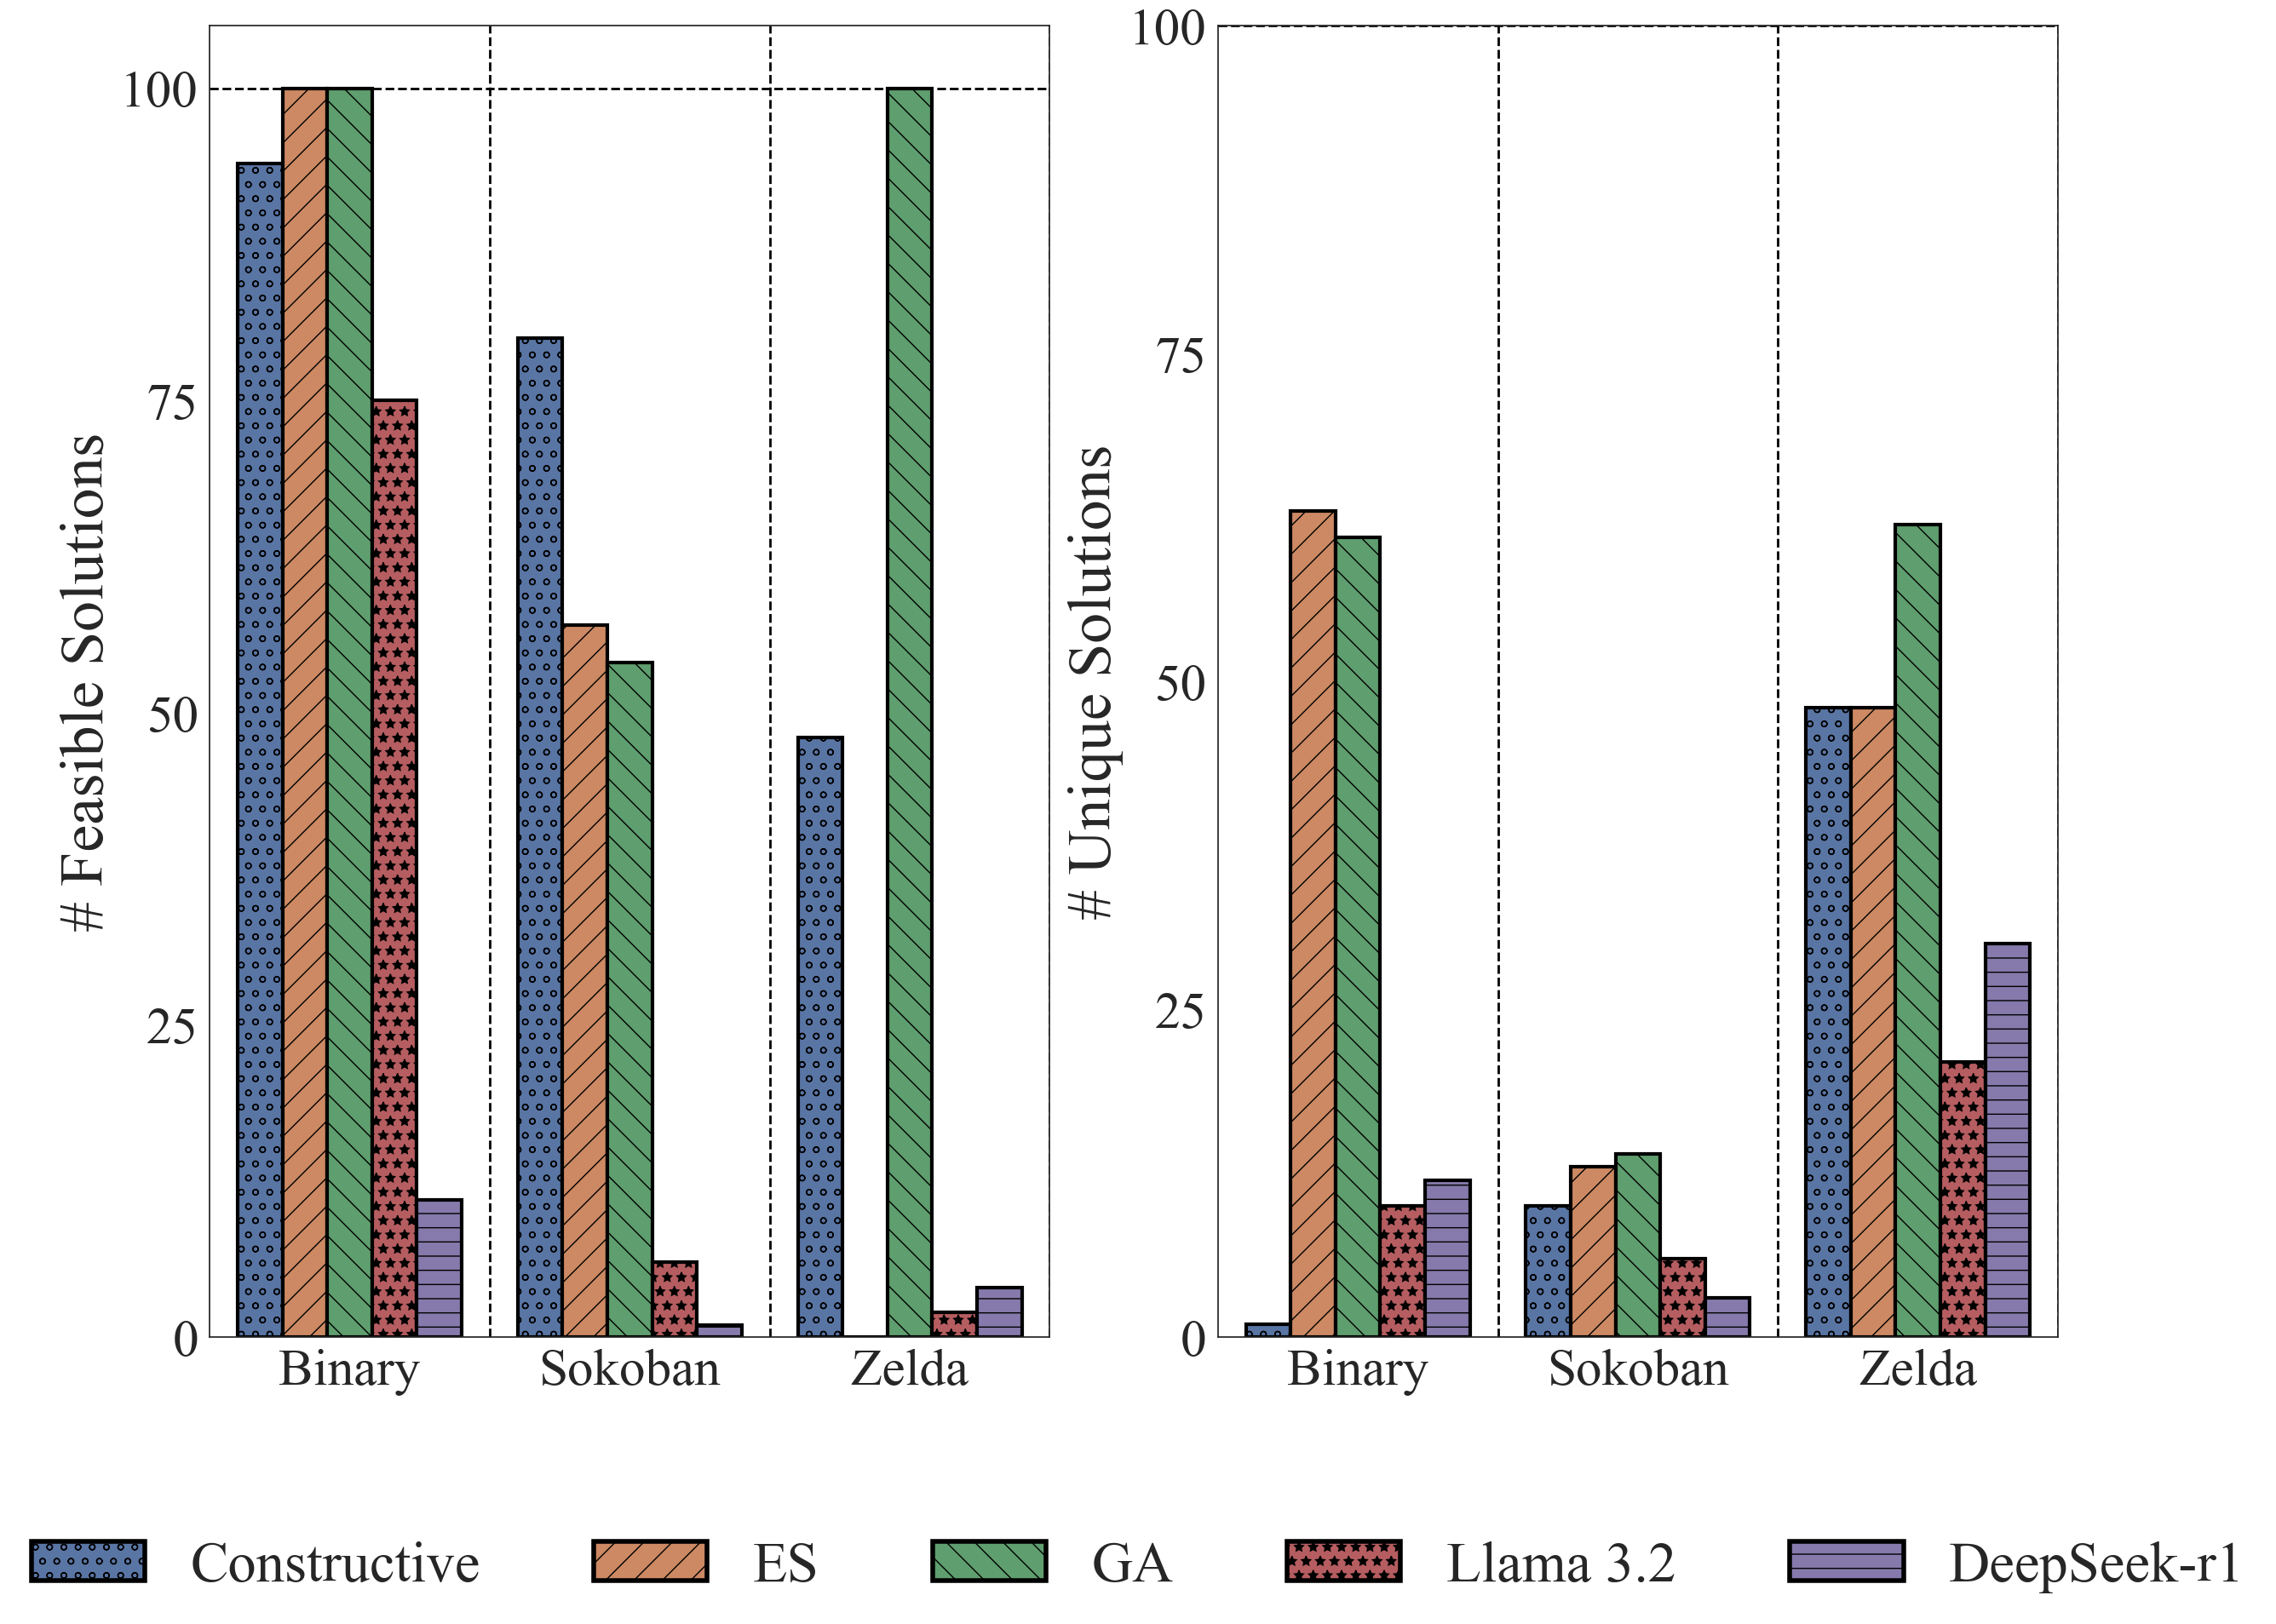

In [17]:
method_to_latex = {
    'constructive': 'Constructive',
    'deepseek-r1': 'DeepSeek-r1',
    'es': 'ES',
    'ga': 'GA',
    'llama3.2': "Llama 3.2"
}

hatches = ['o', '/', '\\', '*', '-']
fig, axes = plt.subplots(1, 2, figsize=(28, 20))

for i, (metric, ylabel) in enumerate(zip(['n_quality', 'n_diversity'], ['# Feasible Solutions', '# Unique Solutions'])):
		ax = axes[i]
		sns.barplot(
					x='env', y=metric, hue='method', hue_order=['constructive', 'es', 'ga', 'llama3.2', 'deepseek-r1'],
					data=grouped_df, linewidth=3, edgecolor='black', gap=2.0, ax=ax,
					# errorbar=('ci', 95), capsize=0.4, err_kws={'color': 'k', 'linewidth': 3}
				)

		for j, patch in enumerate(ax.patches[:-5]):
			patch.set_hatch(hatches[j // len(envs)])

		for j, patch in enumerate(ax.patches[-5:]):
			patch.set_hatch(hatches[j])

		ax.set_xticks(range(len(envs)))
		ax.set_xticklabels([x.capitalize() for x in envs])#, rotation=45, ha='right', rotation_mode='anchor')
		ax.set_xlabel('')

		ax.set_ylabel(ylabel)
		ax.set_yticks([0, 25, 50, 75, 100])

		ax.axhline(100, 0, 1, linestyle='--', linewidth=2, color='black')
		
		for j in range(len(envs)):
			ax.axvline(0.5 + 1.0 * j, 0, 1, linestyle='--', linewidth=2, color='black')

		handles, labels = ax.legend().legend_handles, [t.get_text() for t in ax.legend().texts]

		# Process labels for formatting
		for j, label in enumerate(labels):
			if label == 'method':
				labels[j] = 'Method'
				handles[j].set_linewidth(0.0)  # Hide line for category labels
			labels[j] = method_to_latex[label]

		# Remove duplicate labels
		unique_labels = dict(zip(labels, handles))

		# Remove axis legend... again
		ax.legend([], [], frameon=False)

		if i == 1:
			# Add legend inside the main figure
			legend = fig.legend(unique_labels.values(), unique_labels.keys(),
							loc='lower right',
							bbox_to_anchor=(1, -0.07),
							frameon=False, ncol=len(unique_labels))

			# Increase linewidth of legend handles
			for legend_obj in legend.legend_handles:
				legend_obj.set_linewidth(4.0)
		
plot_filename = os.path.join('./plots', f"altmethods_together.pdf")
fig.savefig(plot_filename, bbox_inches='tight')
plt.show()

plt.close()

In [ ]:
import pcg_benchmark

df_fname = os.path.join(results_dir, "results.csv")
if not os.path.exists(df_fname):
    df = build_df()
else:
    df = pd.read_csv(df_fname)

for method in methods:
	for env_name in envs:
		sub_df = df.loc[(df['method'] == method) & (df['env'] == env_name)]
		for metric in ['quality', 'diversity']:
			sub_df = sub_df.sort_values(by=metric, ascending=False)
			for i in range(4):
				to_plot = sub_df.iloc[i]
				chromosome_fname = os.path.join(results_dir, method, f'{env_name}_{to_plot["chromosome_n"]}.json')
				with open(chromosome_fname, 'r') as chromosome_fp:
					choromosome = json.load(chromosome_fp)

					env = pcg_benchmark.make(f'{env_name}-v0')
					env.render(choromosome['content']).save(os.path.join('./plots', f'{method}_{env_name}_{metric}__{to_plot[metric]:.5f}_{i}.png'))

		